In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [7]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-2.16.1.min.js?noext',
            },
          });
        </script>
        '''))


In [8]:
csv_layoffs="/content/layoffs.csv"

In [9]:
df = pd.read_csv("layoffs.csv", sep=",", encoding="utf-8")
df = pd.DataFrame(df)
df.head(5)

,Id,Nombre,Apellido,Area,Fecha comienzo,Fecha fin,Nivel,Grupo recruitment,Tiempo recruitment,Rango Salarial,RS competencia,Manager,Realizo Cursos
0,1,Romina,Brito,Marketing,03/05/2018,12/31/2018,N3,Grupo B,3,Rango 3,Rango 3,1,SI
1,2,Pedro,Lujan,Compras,03/06/2017,12/31/2021,N3,Grupo B,3,Rango 2,Rango 2,2,SI
2,3,Juan,Albornoz,IT,06/04/2018,04/30/2019,N4,Grupo C,4,Rango 4,Rango 4,5,NO
3,4,Sebastian,González,Legales,05/07/2018,05/30/2021,N2,Grupo A,4,Rango 2,Rango 2,3,SI
4,5,Franco,Rodríguez,Marketing,05/01/2017,11/30/2017,N5,Grupo C,6,Rango 5,Rango 4,1,SI


In [10]:
df.shape

(30, 13)

Ideas de Aspectos a explorar:

*   Distribución de despidos en el tiempo
*   Tendencias marcadas grupos, para encontrar cuando se hizo una reducción de un area, o una reducción de banda salarial o reducción basada en antigüedad o una combinación recurrente de 2 o las 3 opciones.
*   Ver si No tener cursos es mas frecuente para un Manager
*   Ver si un Grupo de recruitment se destaca por muchos despidos o pocos despidos
*    Ver si hacer cursos mejora la propuesta de la competencia (solo 2 han tenido mejores propuestas)
*    Analizar qué grupo recruitment tuvo reclutaciones más largas
*    Ver qué manager tuvo más despidos









# Data prep


In [11]:
# Revisar que no haya datos repetidos (por id)
print("Si da 0, no hay repetidos")
df.shape[0] - df['Id'].nunique()

Si da 0, no hay repetidos


0

In [12]:
# Revisar que no haya datos repetidos (por nombre completo)
df['Nombre completo'] = df['Nombre'] + ' ' + df['Apellido']
df['Nombre completo']

print("Si da 0, no hay repetidos")
df.shape[0] - df['Nombre completo'].nunique()

Si da 0, no hay repetidos


0

In [13]:
# Podemos borrar las columnas que no sean de utilidad, en este caso id, nombre y apellido
df.drop(['Id', 'Nombre', 'Apellido', 'Nombre completo'], axis=1, inplace=True)
df.columns

Index(['Area', 'Fecha comienzo', 'Fecha fin', 'Nivel', 'Grupo recruitment',
       'Tiempo recruitment', 'Rango Salarial', 'RS competencia', 'Manager',
       'Realizo Cursos'],
      dtype='object')

In [14]:
# Manager y tiempo recruitment como variables categóricas
df['Manager'] = (df['Manager']).astype('category')
df['Tiempo recruitment'] = (df['Tiempo recruitment']).astype('category')

In [15]:
# Creo una variable "Rango Salarial vs RS competencia"
df["Diferencia RS vs competencia"] = df["Rango Salarial"].str.extract(r"(\d+)").astype(int) - df["RS competencia"].str.extract(r"(\d+)").astype(int)
print(df[["Rango Salarial", "RS competencia", "Diferencia RS vs competencia"]].sort_values(by="Diferencia RS vs competencia").head())
print(df[["Rango Salarial", "RS competencia", "Diferencia RS vs competencia"]].sort_values(by="Diferencia RS vs competencia").tail())

   Rango Salarial RS competencia  Diferencia RS vs competencia
25        Rango 2        Rango 3                            -1
18        Rango 4        Rango 5                            -1
0         Rango 3        Rango 3                             0
27        Rango 6        Rango 6                             0
26        Rango 2        Rango 2                             0
   Rango Salarial RS competencia  Diferencia RS vs competencia
13        Rango 3        Rango 3                             0
29        Rango 1        Rango 1                             0
12        Rango 4        Rango 3                             1
20        Rango 6        Rango 5                             1
4         Rango 5        Rango 4                             1


In [16]:
# Que las fechas sean fechas
df['Fecha comienzo'] = pd.to_datetime(df['Fecha comienzo'])
df['Fecha fin'] = pd.to_datetime(df['Fecha fin'])

In [17]:
# Que Realizo Cursos sea un booleano
# A revisar si conviene que sea booleano o no
df['Realizo Cursos'] = df['Realizo Cursos'].apply(lambda x: True if x == 'SI' else False).astype("category")
df['Realizo Cursos'].head()

0     True
1     True
2    False
3     True
4     True
Name: Realizo Cursos, dtype: category
Categories (2, bool): [False, True]

In [18]:
# Que es tiempo recruitment?

df['Tiempo recruitment'].unique()

# Intuyo que es meses
# (Comentario Ale) Pueden ser meses que duró el proceso de reclutamiento o cantidad de entrevistas quizás

[3, 4, 6, 5]
Categories (4, int64): [3, 4, 5, 6]

In [19]:
# Veamos la antiguedad en años

df['Antiguedad'] = np.round((df['Fecha fin'] - df['Fecha comienzo']).dt.days/365, 2)
df.sample(15)

,Area,Fecha comienzo,Fecha fin,Nivel,Grupo recruitment,Tiempo recruitment,Rango Salarial,RS competencia,Manager,Realizo Cursos,Diferencia RS vs competencia,Antiguedad
24,Ventas,2021-07-05,2022-02-28,N7,Grupo B,4,Rango 6,Rango 6,8,True,0,0.65
20,Compras,2017-11-06,2020-12-31,N5,Grupo C,4,Rango 6,Rango 5,2,True,1,3.15
17,Marketing,2017-04-03,2019-12-31,N3,Grupo B,4,Rango 3,Rango 3,9,True,0,2.75
3,Legales,2018-05-07,2021-05-30,N2,Grupo A,4,Rango 2,Rango 2,3,True,0,3.07
23,Producción,2019-01-07,2021-12-31,N6,Grupo A,5,Rango 6,Rango 6,4,True,0,2.98
26,Compras,2019-06-03,2022-04-30,N2,Grupo A,4,Rango 2,Rango 2,2,True,0,2.91
1,Compras,2017-03-06,2021-12-31,N3,Grupo B,3,Rango 2,Rango 2,2,True,0,4.82
18,Auditoria,2018-02-05,2021-01-30,N4,Grupo A,4,Rango 4,Rango 5,10,False,-1,2.99
21,Ventas,2018-12-03,2021-06-30,N4,Grupo B,3,Rango 4,Rango 4,8,True,0,2.58
29,Auditoria,2021-09-06,2022-06-30,N1,Grupo C,3,Rango 1,Rango 1,10,True,0,0.81


In [20]:
# Chequeo que no haya ninguna antigüedad negativa
print("Cantidad de registros con antigüedad negativa")
df[df['Antiguedad'] < 0].shape[0]

Cantidad de registros con antigüedad negativa


0

In [21]:
# Veamos la antiguedad en días

df['Antiguedad dias'] = np.round((df['Fecha fin'] - df['Fecha comienzo']).dt.days, 2)
df[["Fecha comienzo", "Fecha fin", "Antiguedad dias", "Antiguedad"]].head(5)

,Fecha comienzo,Fecha fin,Antiguedad dias,Antiguedad
0,2018-03-05,2018-12-31,301,0.82
1,2017-03-06,2021-12-31,1761,4.82
2,2018-06-04,2019-04-30,330,0.90
3,2018-05-07,2021-05-30,1119,3.07
4,2017-05-01,2017-11-30,213,0.58


In [22]:
# Creo nueva variable categórica relacionada con la antiguedad en días

df["Antiguedad en dias"] = pd.qcut(df["Antiguedad dias"], q=4)
df[["Antiguedad dias", "Antiguedad en dias"]].sort_values(by="Antiguedad dias").head()

,Antiguedad dias,Antiguedad en dias
11,171,"(170.999, 298.0]"
22,179,"(170.999, 298.0]"
4,213,"(170.999, 298.0]"
24,238,"(170.999, 298.0]"
19,267,"(170.999, 298.0]"


In [23]:
# Veamos la antiguedad en semanas

df['Antiguedad semanas'] = np.round((df['Fecha fin'] - df['Fecha comienzo']).dt.days, 2)
df[["Fecha comienzo", "Fecha fin", "Antiguedad semanas", "Antiguedad"]].head(5)

,Fecha comienzo,Fecha fin,Antiguedad semanas,Antiguedad
0,2018-03-05,2018-12-31,301,0.82
1,2017-03-06,2021-12-31,1761,4.82
2,2018-06-04,2019-04-30,330,0.90
3,2018-05-07,2021-05-30,1119,3.07
4,2017-05-01,2017-11-30,213,0.58


# Data Analysis

In [24]:
df.describe()

,Fecha comienzo,Fecha fin,Diferencia RS vs competencia,Antiguedad,Antiguedad dias,Antiguedad semanas
count,30,30,30.000000,30.000000,30.000000,30.000000
mean,2019-04-23 09:36:00,2021-05-20 20:48:00,0.033333,2.077333,758.466667,758.466667
min,2017-01-02 00:00:00,2017-11-30 00:00:00,-1.000000,0.470000,171.000000,171.000000
25%,2018-03-20 18:00:00,2020-12-31 00:00:00,0.000000,0.812500,298.000000,298.000000
50%,2019-03-04 00:00:00,2021-10-30 12:00:00,0.000000,2.440000,891.000000,891.000000
75%,2020-06-27 06:00:00,2022-03-23 06:00:00,0.000000,2.997500,1093.750000,1093.750000
max,2022-01-03 00:00:00,2022-07-01 00:00:00,1.000000,4.820000,1761.000000,1761.000000
std,NaN,NaN,0.413841,1.302202,475.210787,475.210787


In [25]:
# Gente que recibió una mejor propuesta

growths = df[df['Diferencia RS vs competencia'] < 0]
growths

,Area,Fecha comienzo,Fecha fin,Nivel,Grupo recruitment,Tiempo recruitment,Rango Salarial,RS competencia,Manager,Realizo Cursos,Diferencia RS vs competencia,Antiguedad,Antiguedad dias,Antiguedad en dias,Antiguedad semanas
18,Auditoria,2018-02-05,2021-01-30,N4,Grupo A,4,Rango 4,Rango 5,10,False,-1,2.99,1090,"(891.0, 1093.75]",1090
25,Producción,2018-05-07,2021-09-30,N3,Grupo B,3,Rango 2,Rango 3,6,True,-1,3.40,1242,"(1093.75, 1761.0]",1242


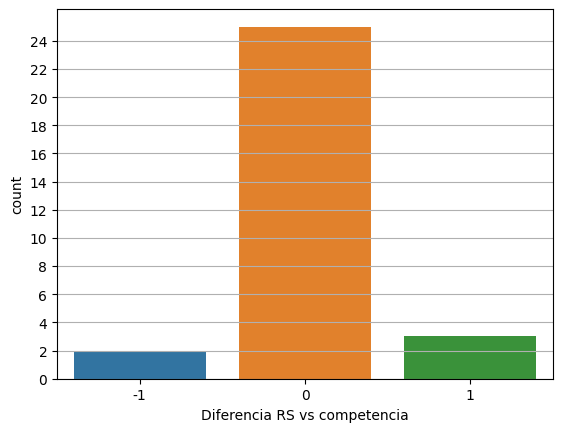

In [26]:
sns.countplot(data=df, x="Diferencia RS vs competencia")
plt.grid(axis="y")
plt.yticks(ticks=range(0,26,2))
plt.show()

Cantidad de outliers: 0
Límites: -895.625 / 2287.375


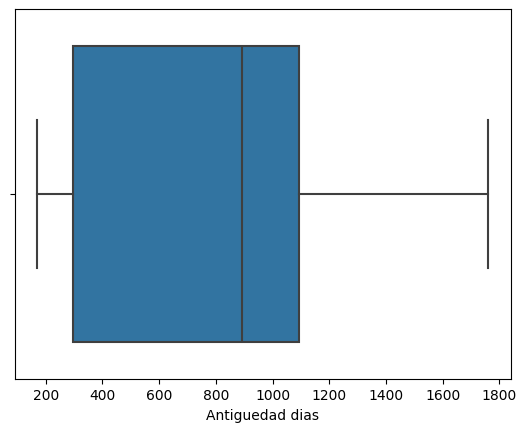

c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


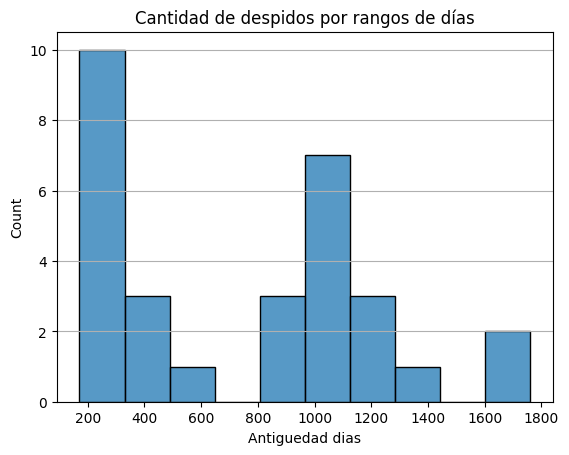

In [27]:
Q1 = df["Antiguedad dias"].quantile(0.25)
Q3 = df["Antiguedad dias"].quantile(0.75)
IQR = Q3 - Q1

# Definimos los límites
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Detectamos los outliers
outliers = df[(df["Antiguedad dias"] < limite_inferior) | (df["Antiguedad dias"] > limite_superior)]

print("Cantidad de outliers:", outliers.shape[0])
print("Límites:", limite_inferior, "/", limite_superior)

sns.boxplot(data=df, x="Antiguedad dias")
plt.show()
sns.histplot(data=df, x="Antiguedad dias", bins=10)
plt.grid(axis="y")
plt.title("Cantidad de despidos por rangos de días")
plt.show()


In [28]:
df["Antiguedad dias"].describe()

count      30.000000
mean      758.466667
std       475.210787
min       171.000000
25%       298.000000
50%       891.000000
75%      1093.750000
max      1761.000000
Name: Antiguedad dias, dtype: float64

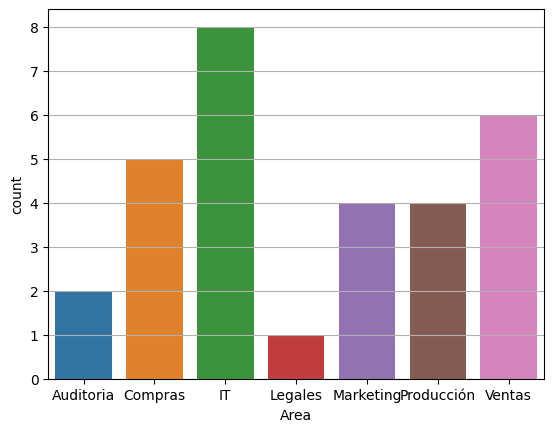

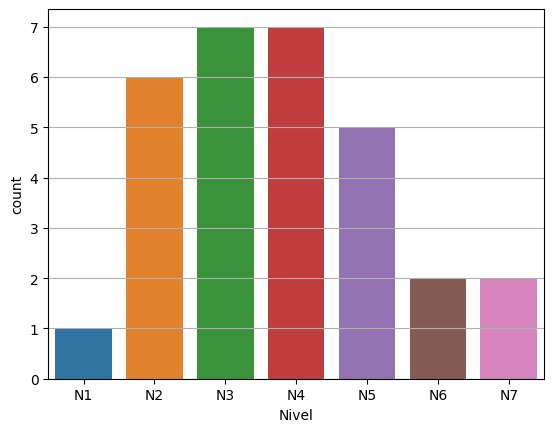

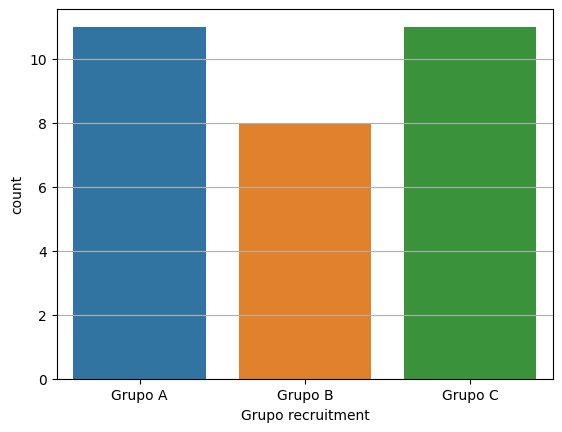

c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


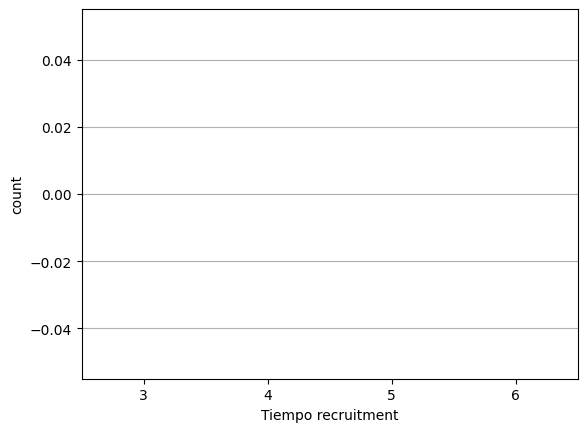

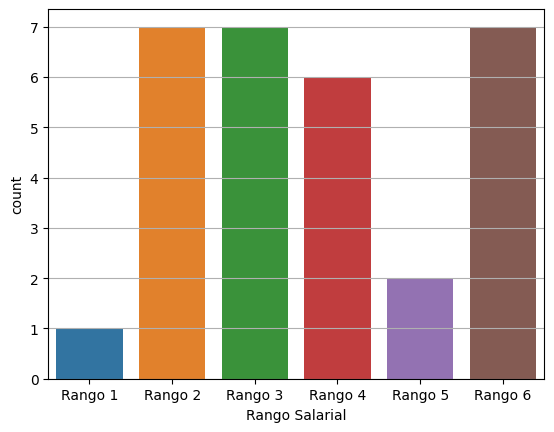

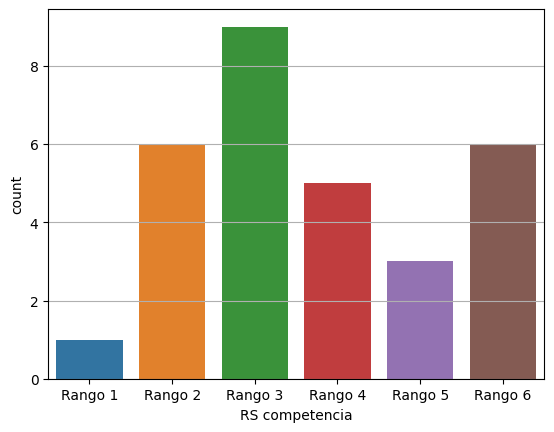

c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


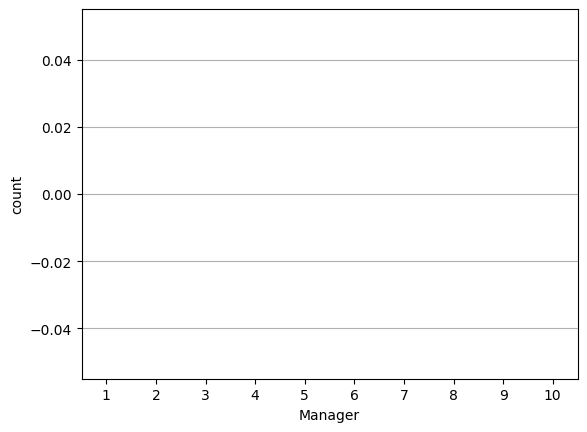

c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


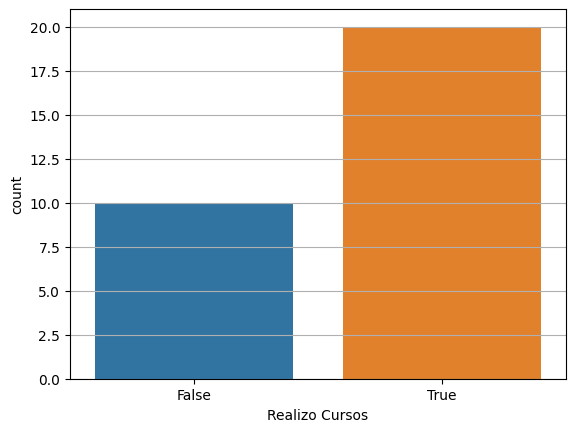

c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


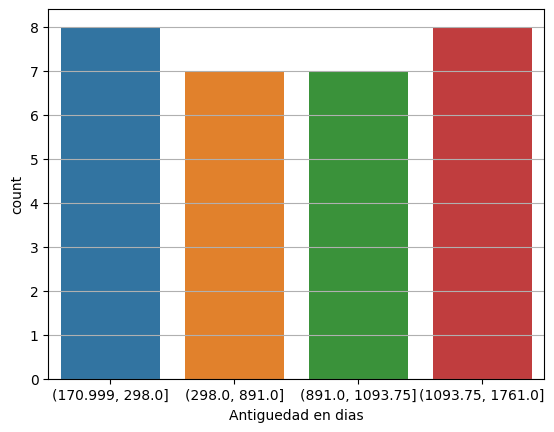

In [29]:
# Gráficos que combinan todos los pares de variables categóricas

# Orden para las variables
orden_variables = {
  "Nivel": ['N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7'],
  "Grupo recruitment": ['Grupo A', 'Grupo B', 'Grupo C'],
  "Rango Salarial": ['Rango 1', 'Rango 2', 'Rango 3', 'Rango 4', 'Rango 5', 'Rango 6'],
  "RS competencia": ['Rango 1', 'Rango 2', 'Rango 3', 'Rango 4', 'Rango 5', 'Rango 6'],
  "Area": ['Auditoria', 'Compras', 'IT', 'Legales', 'Marketing', 'Producción', 'Ventas'],
  "Manager": ["1","2","3","4","5","6","7","8","9","10"],
  "Tiempo recruitment": ["3","4","5","6"],
  "Antiguedad en dias": None,
  "Realizo Cursos": None
}

colores = {
    "Nivel": ['#FFEBEB', '#FFCECE', '#FFB1B1', '#FF9494', '#FF7777', '#FF5A5A', '#FF3D3D'],
    "Grupo recruitment": ['#FFB3B3', '#FF6666', '#FF1A1A'],
    "Rango Salarial": ['#FFE5E5', '#FFCCCC', '#FFB2B2', '#FF9999', '#FF7F7F', '#FF6666'],
    "RS competencia": ['#FFE5E5', '#FFCCCC', '#FFB2B2', '#FF9999', '#FF7F7F', '#FF6666'],
    "Area": ['#FFEAEA', '#FFD5D5', '#FFC0C0', '#FFABAB', '#FF9696', '#FF8181', '#FF6C6C'],
    "Antiguedad en dias": ['#FFEAEA', '#FFC0C0', '#FF9696', '#FF6C6C'],
    "Tiempo recruitment": ['#FFEAEA', '#FFC0C0', '#FF9696', '#FF6C6C'],
    "Manager": ["#FFF0F0","#FFDADA","#FFC4C4","#FFADAD","#FF9797","#FF8080","#FF6A6A","#FF5454","#FF3E3E","#FF2828"],
    "Realizo Cursos": ["#FFB3B3", "#FF1A1A"]
}

# 1. Detectar variables categóricas (tipo object o category)
categoricas = df.select_dtypes(include=["object", "category"]).columns

for variable in categoricas:
    sns.countplot(df, x=variable, order=orden_variables[variable])
    plt.grid(axis="y")
    plt.show()

Area, Nivel


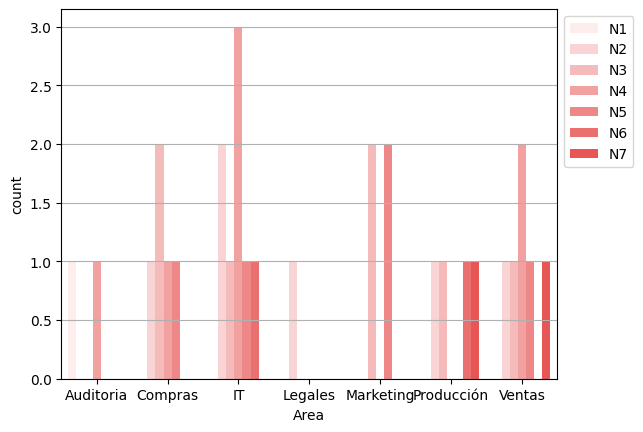

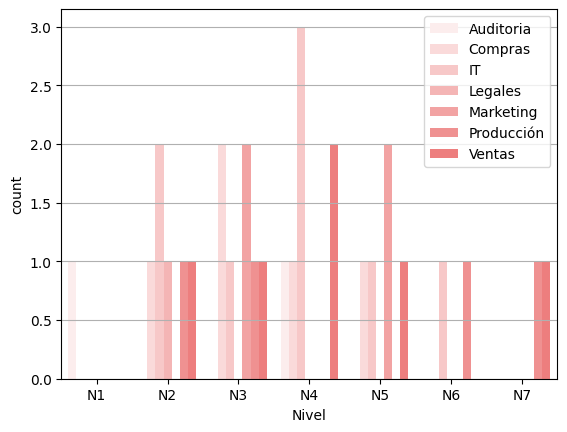

Area, Grupo recruitment


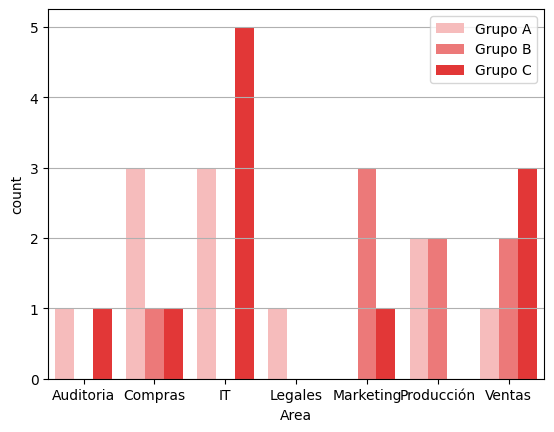

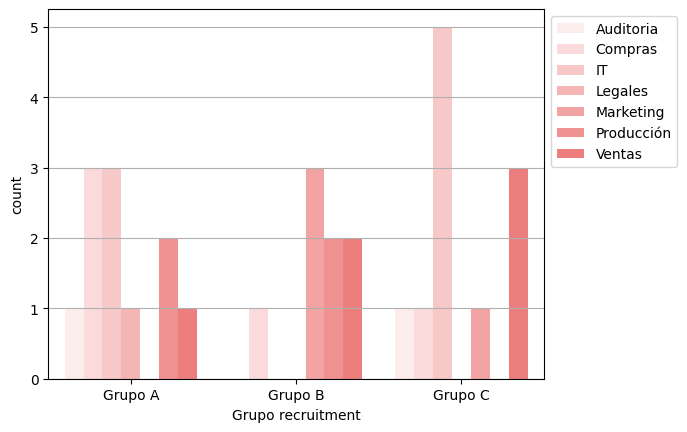

Area, Tiempo recruitment


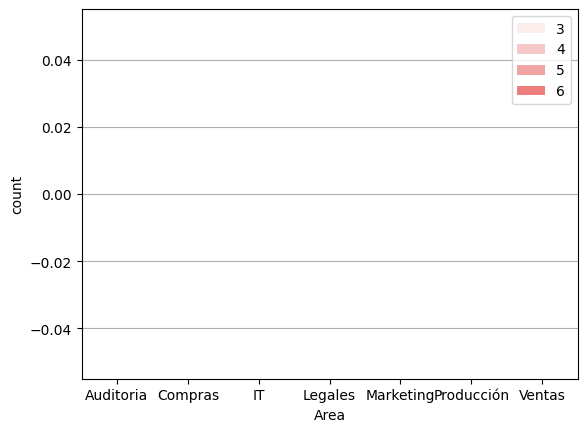

c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


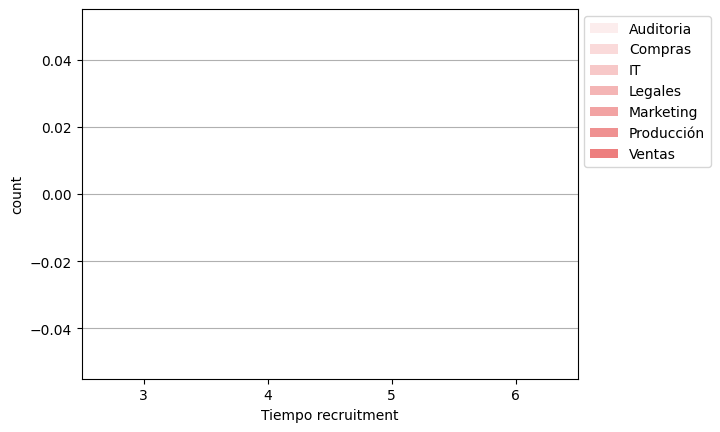

Area, Rango Salarial


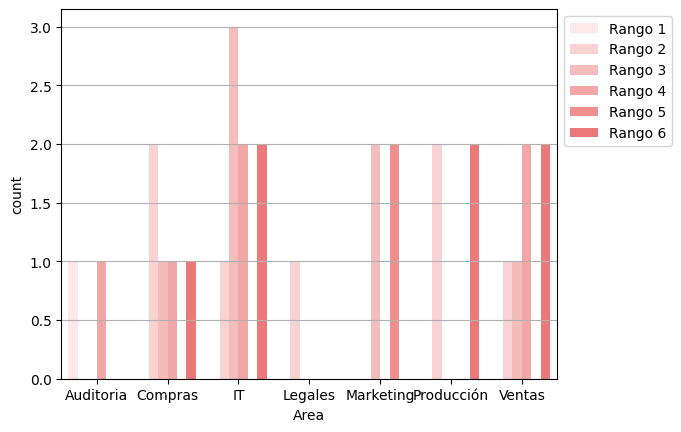

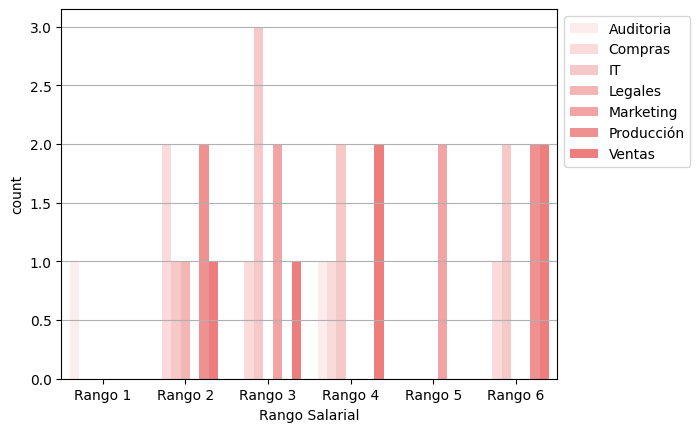

Area, RS competencia


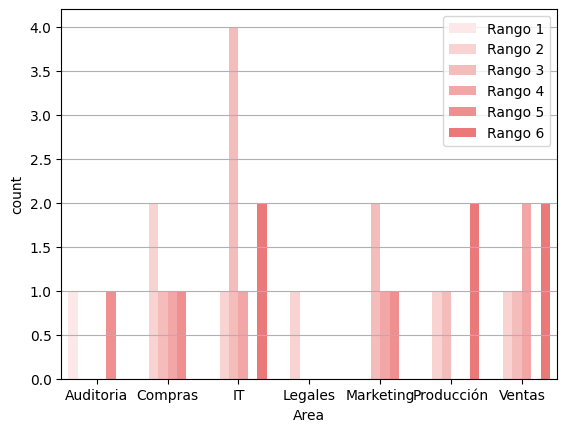

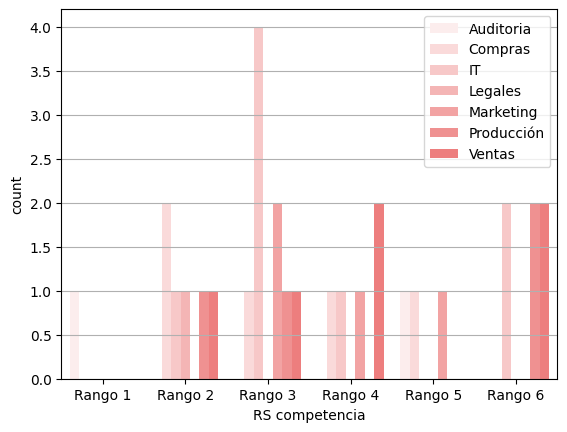

Area, Manager
Area, Realizo Cursos


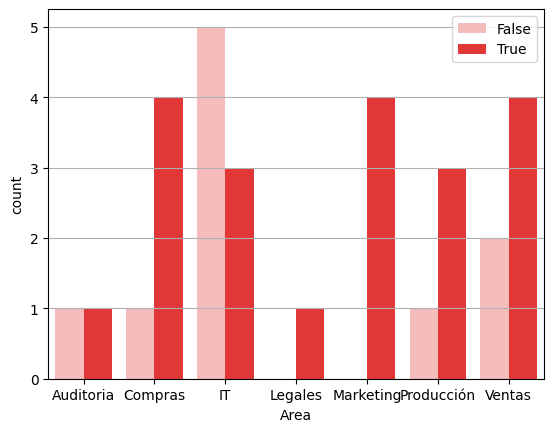

c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


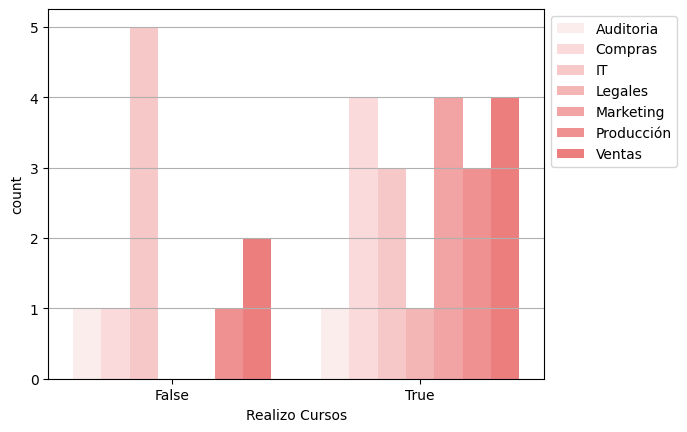

Area, Antiguedad en dias


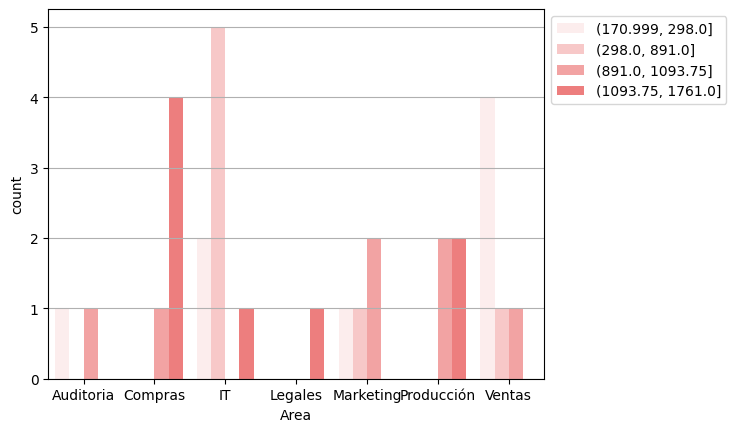

c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


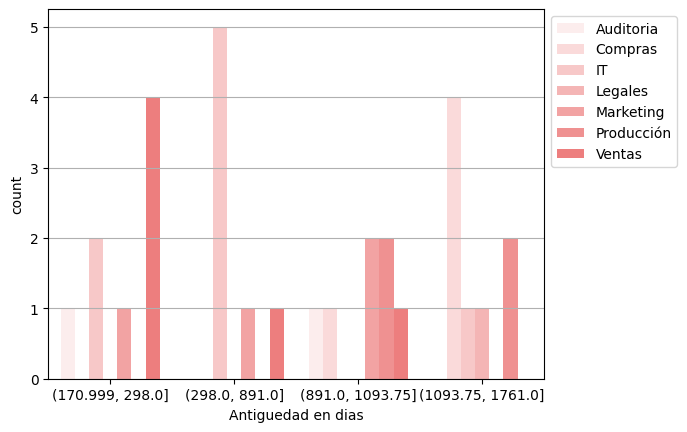

Nivel, Grupo recruitment


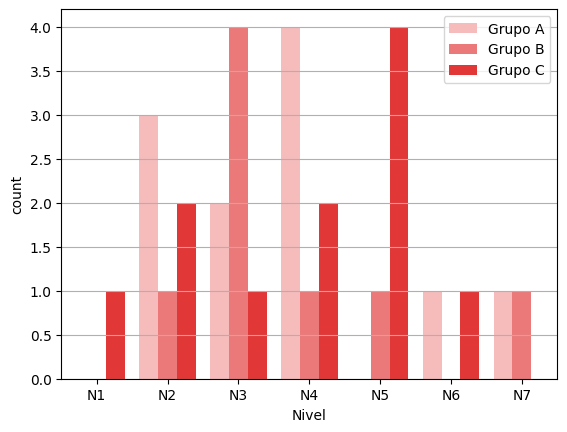

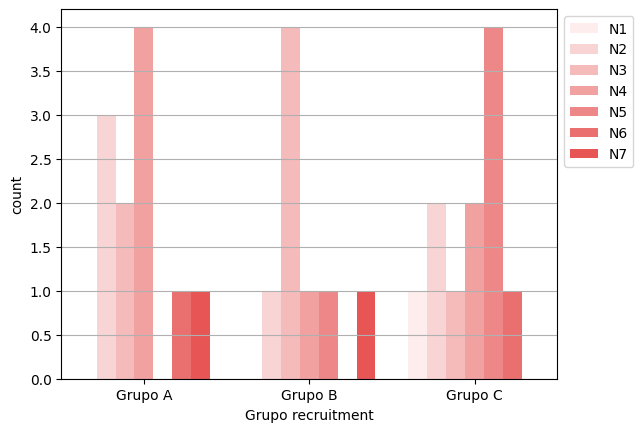

Nivel, Tiempo recruitment


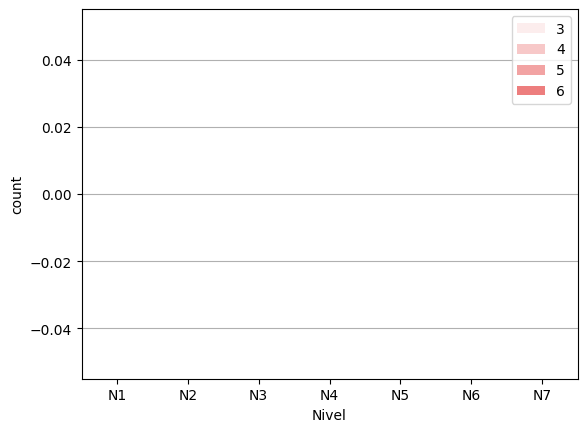

c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


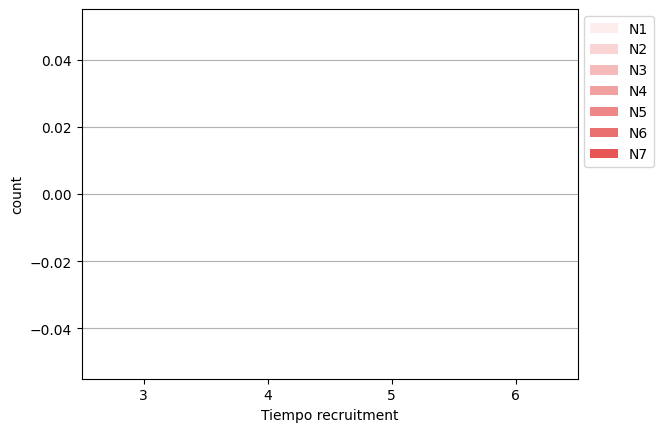

Nivel, Rango Salarial


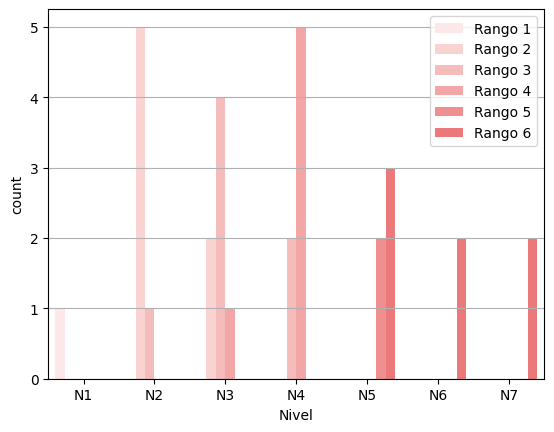

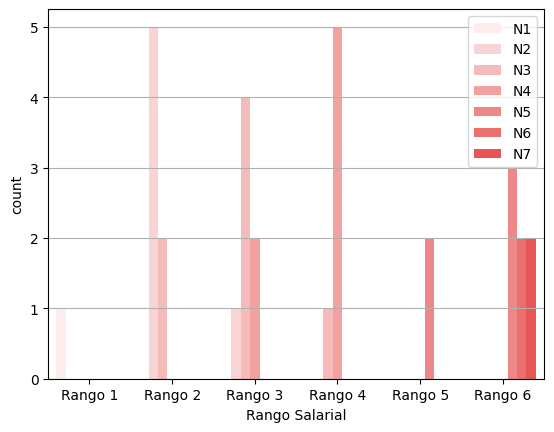

Nivel, RS competencia


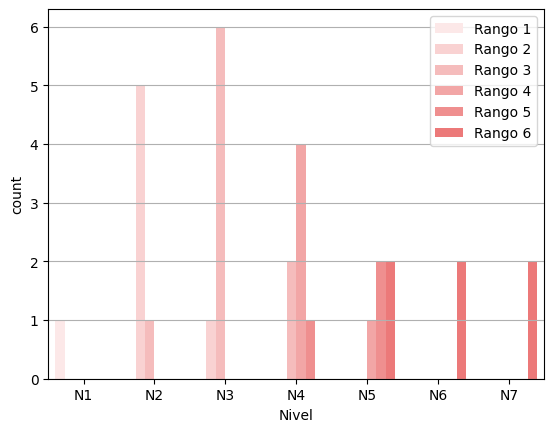

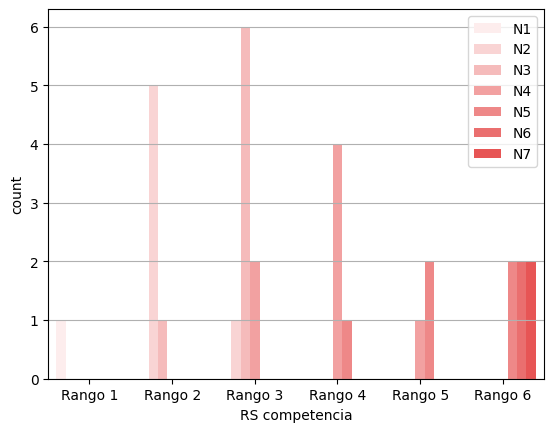

Nivel, Manager
Nivel, Realizo Cursos


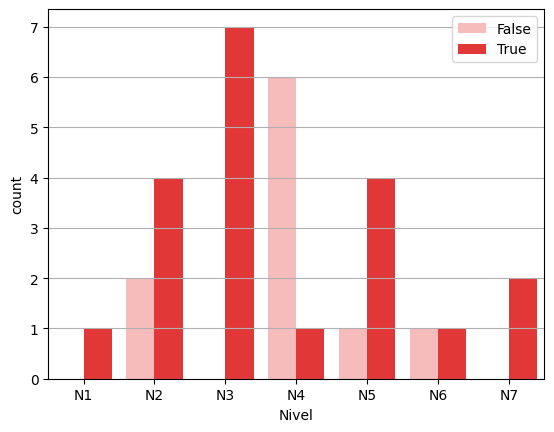

c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


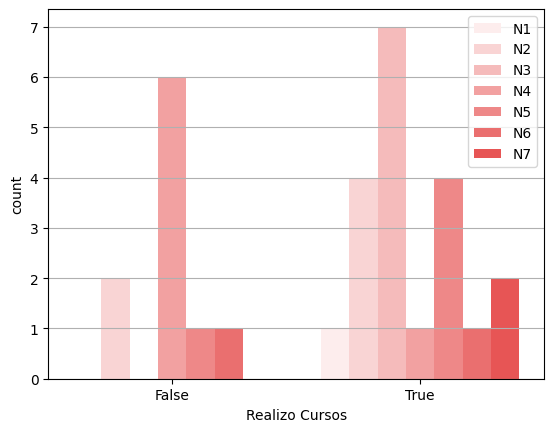

Nivel, Antiguedad en dias


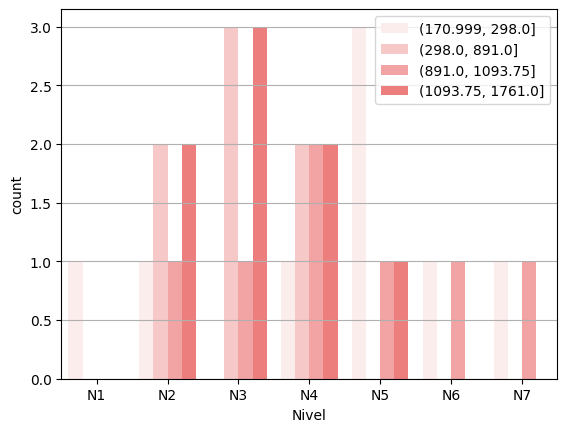

c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


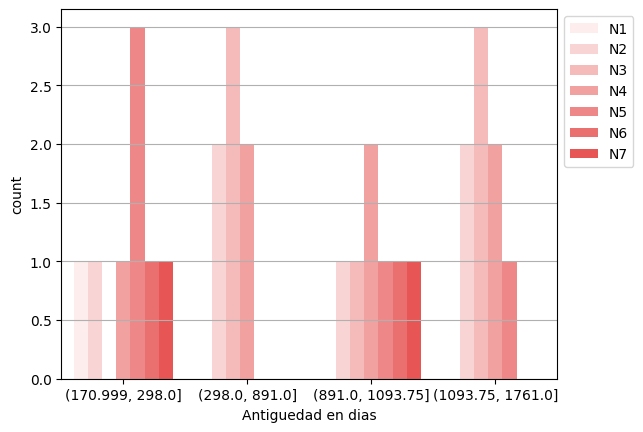

Grupo recruitment, Tiempo recruitment


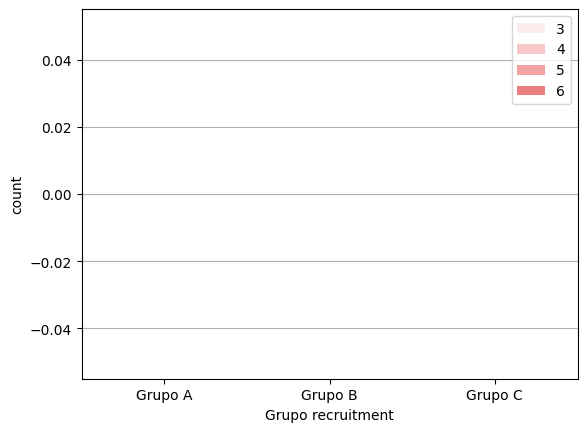

c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


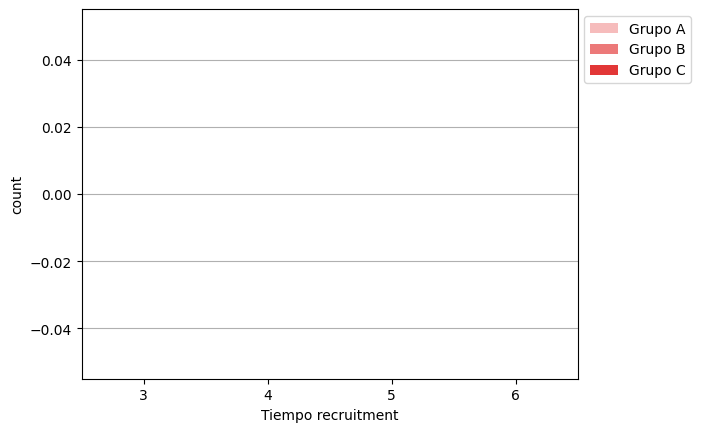

Grupo recruitment, Rango Salarial


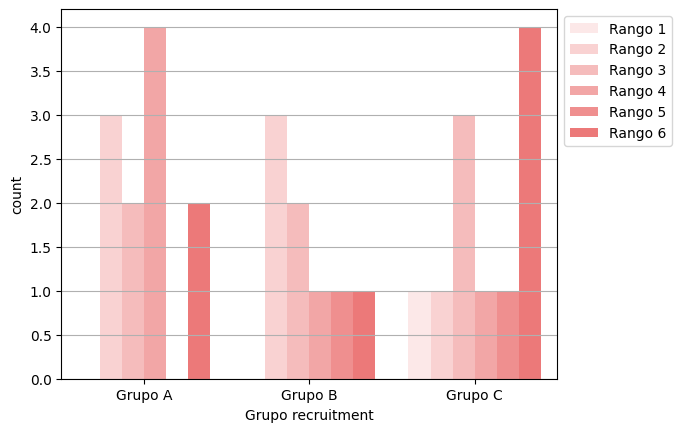

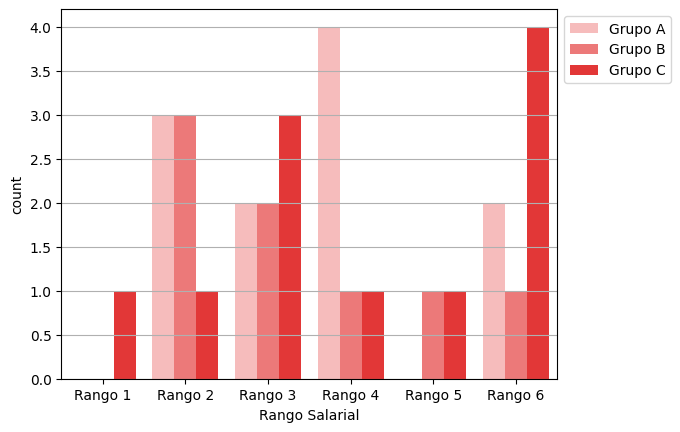

Grupo recruitment, RS competencia


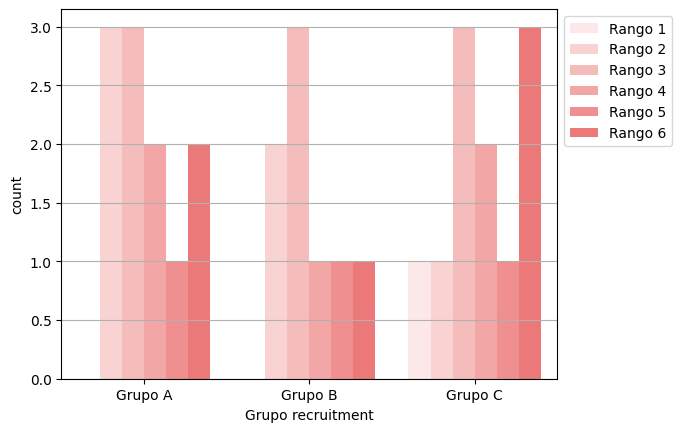

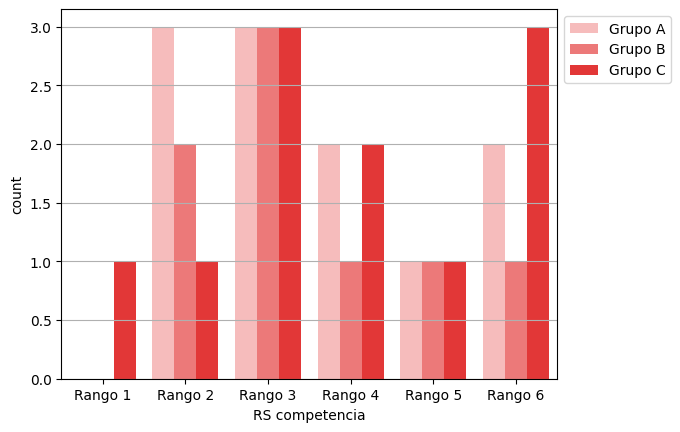

Grupo recruitment, Manager
Grupo recruitment, Realizo Cursos


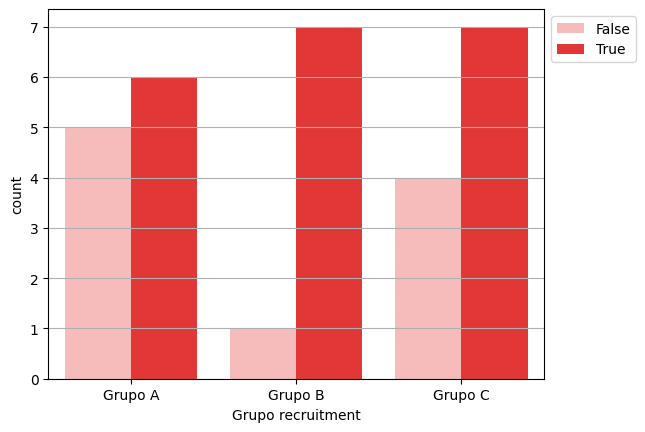

c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


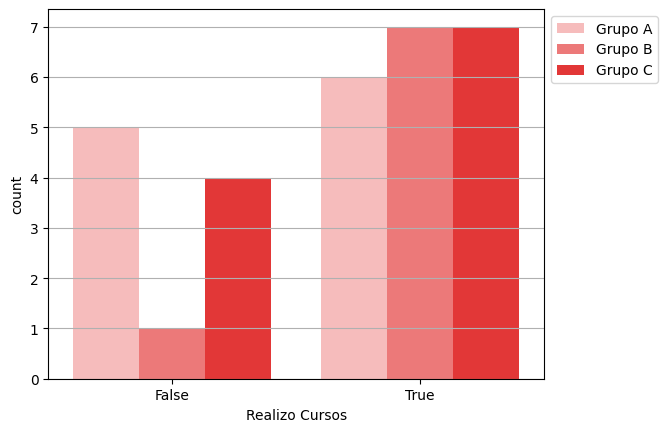

Grupo recruitment, Antiguedad en dias


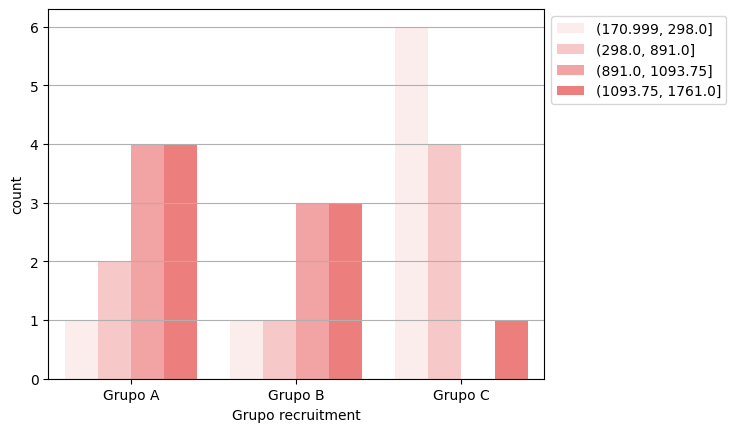

c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


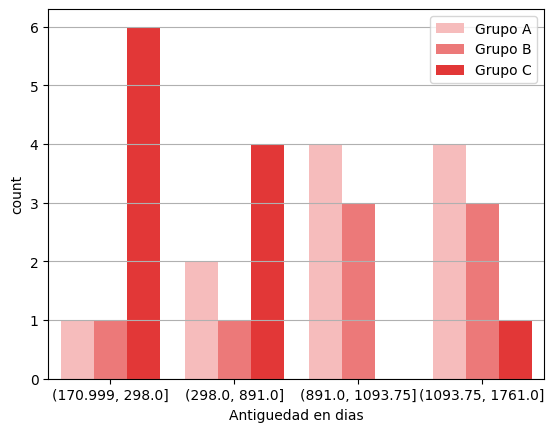

c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


Tiempo recruitment, Rango Salarial


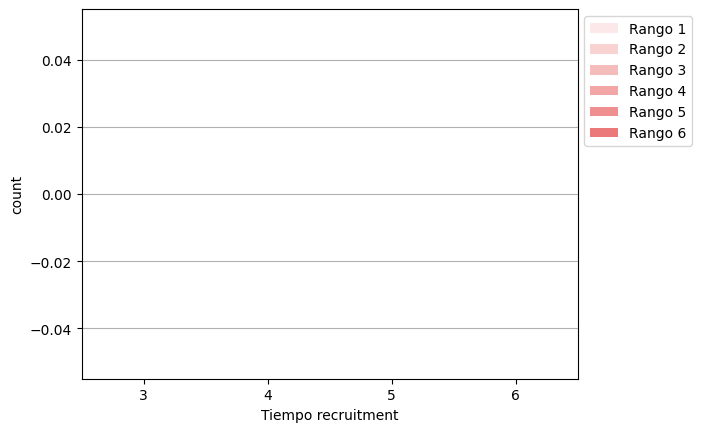

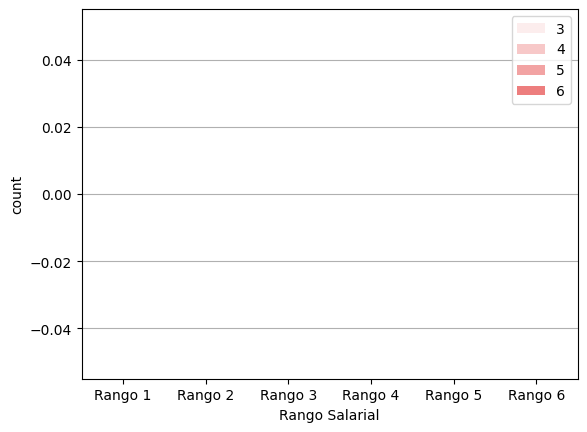

Tiempo recruitment, RS competencia


c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


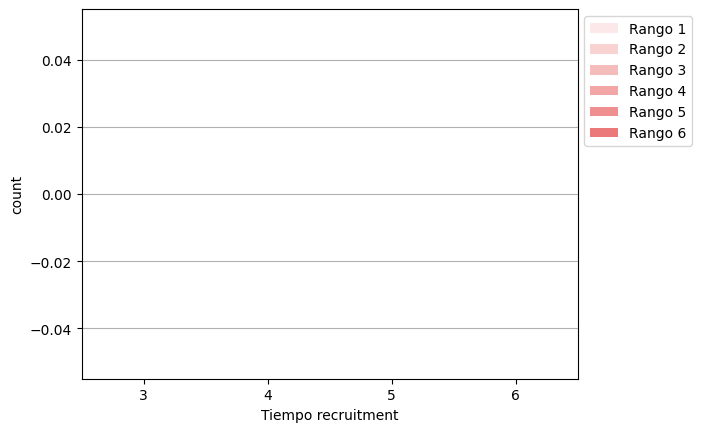

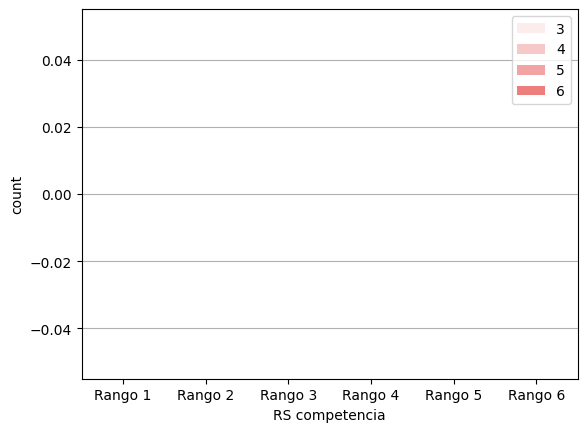

Tiempo recruitment, Manager
Tiempo recruitment, Realizo Cursos


c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


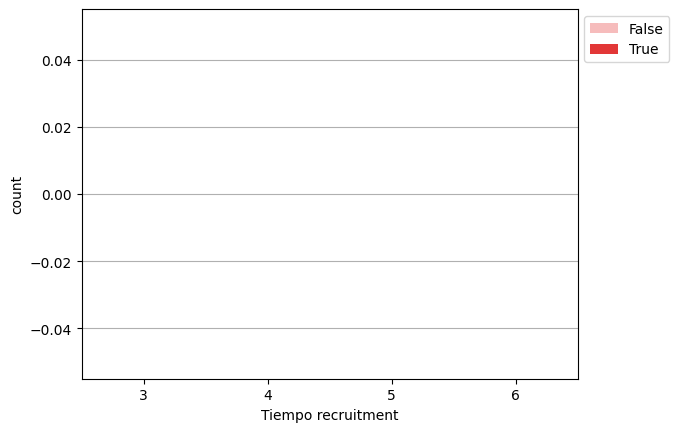

c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


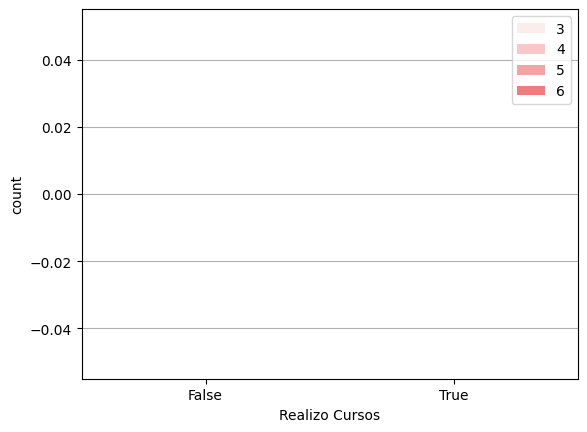

Tiempo recruitment, Antiguedad en dias


c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


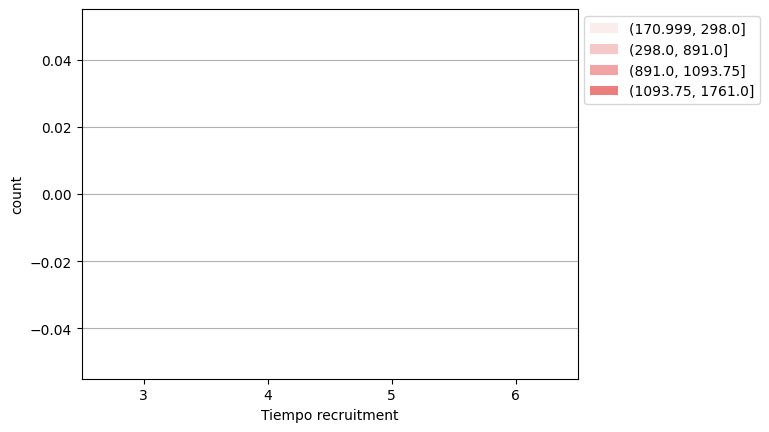

c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


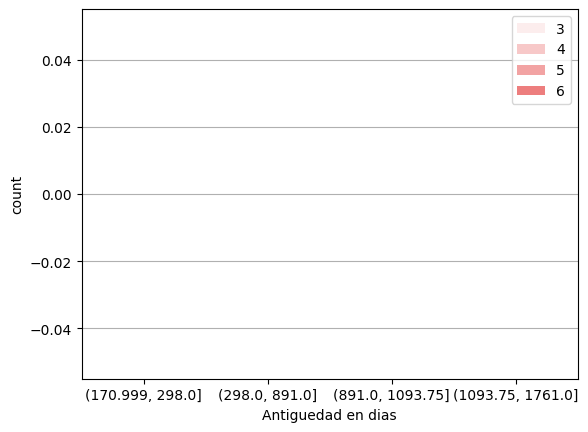

Rango Salarial, RS competencia


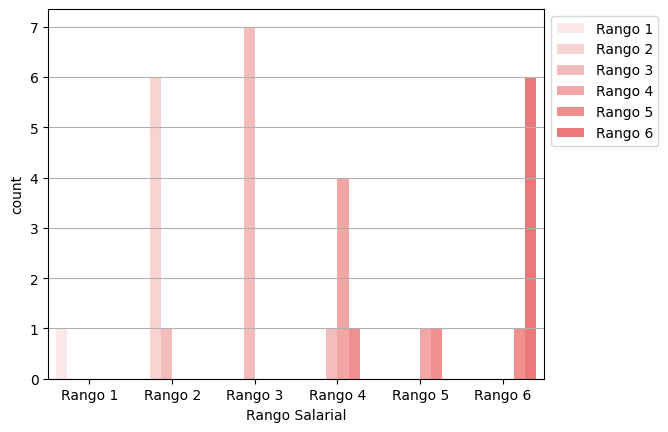

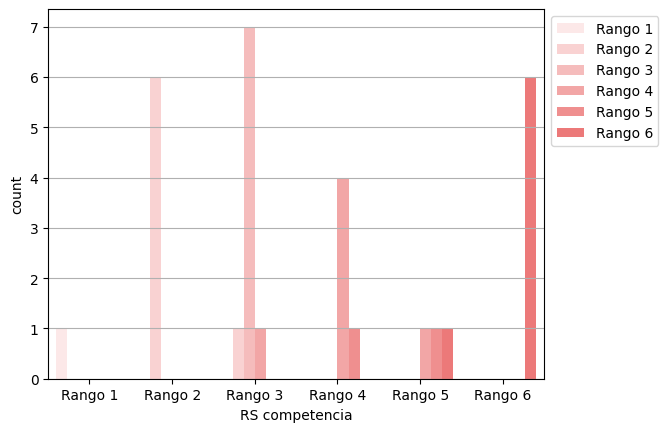

Rango Salarial, Manager
Rango Salarial, Realizo Cursos


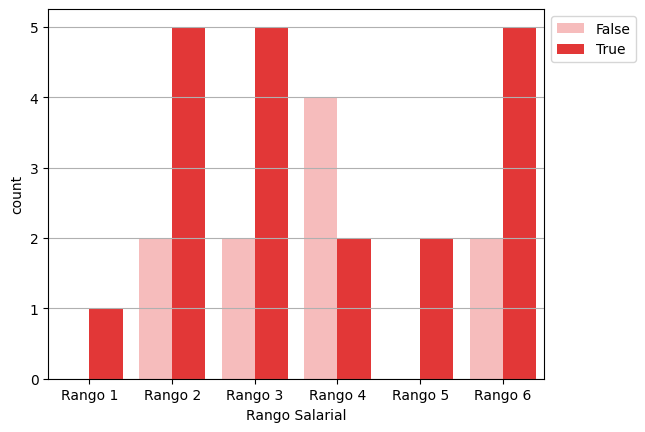

c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


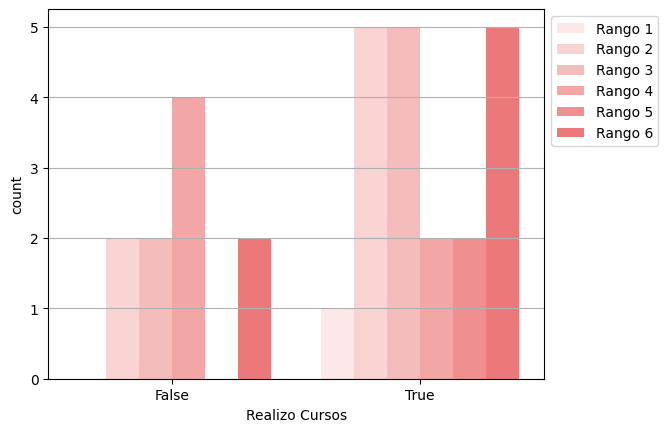

Rango Salarial, Antiguedad en dias


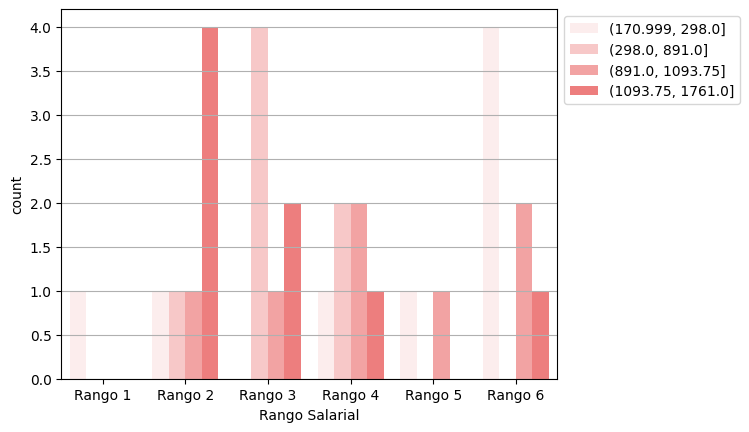

c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


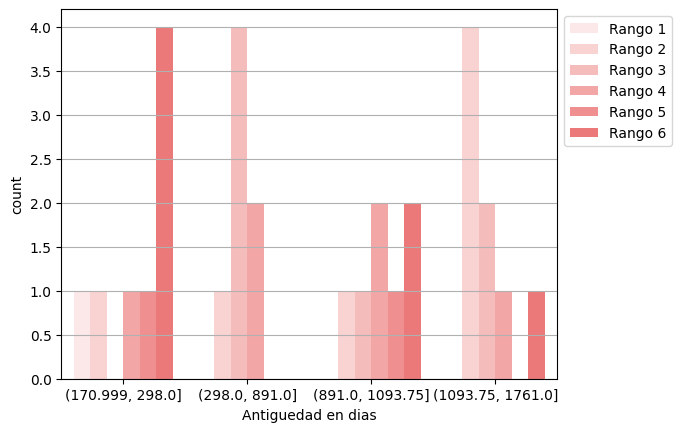

RS competencia, Manager
RS competencia, Realizo Cursos


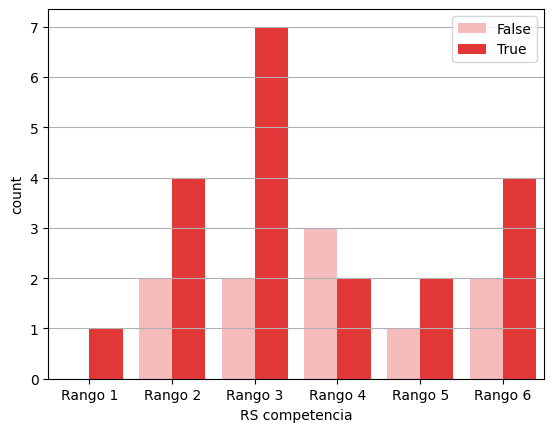

c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


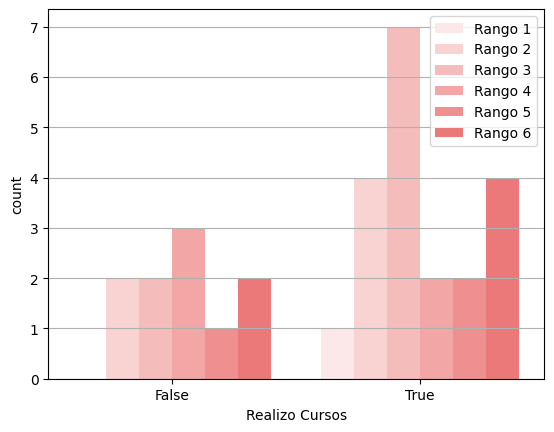

RS competencia, Antiguedad en dias


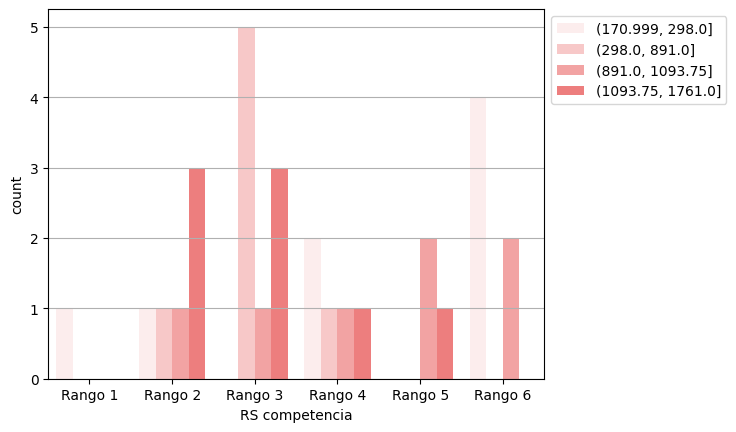

c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


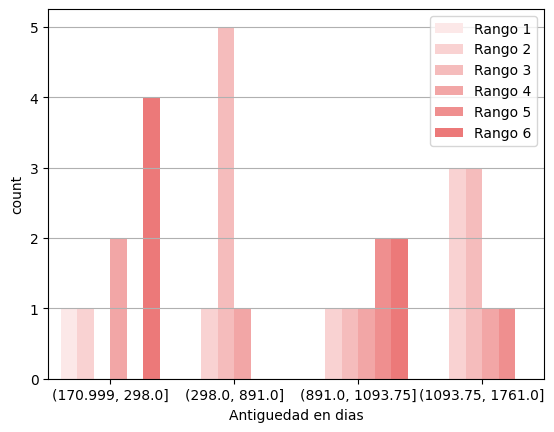

c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


Manager, Realizo Cursos


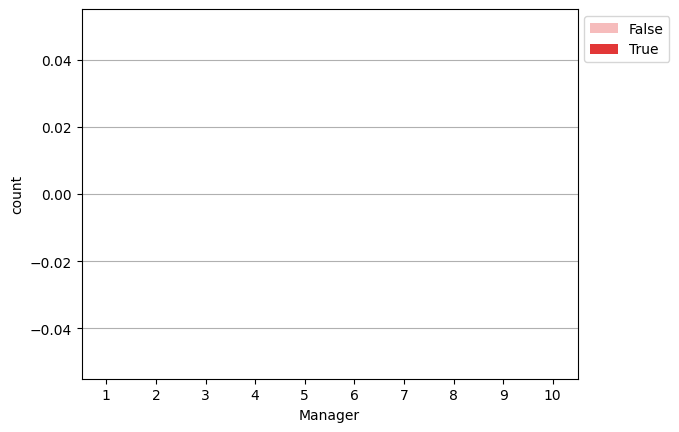

c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


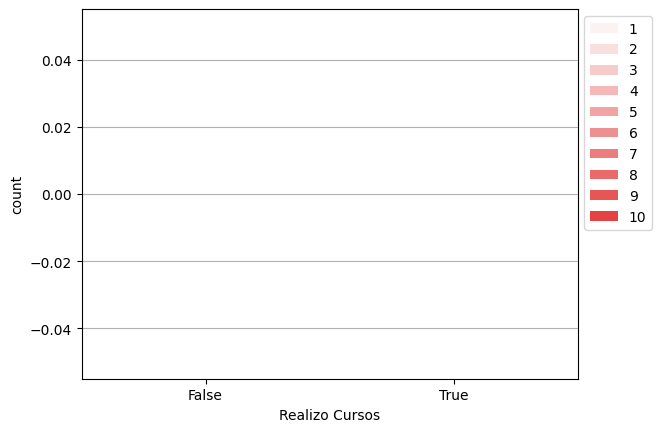

c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


Manager, Antiguedad en dias


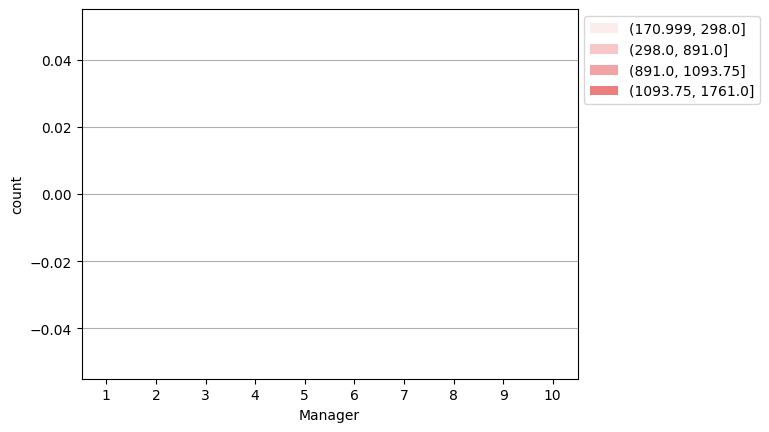

c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


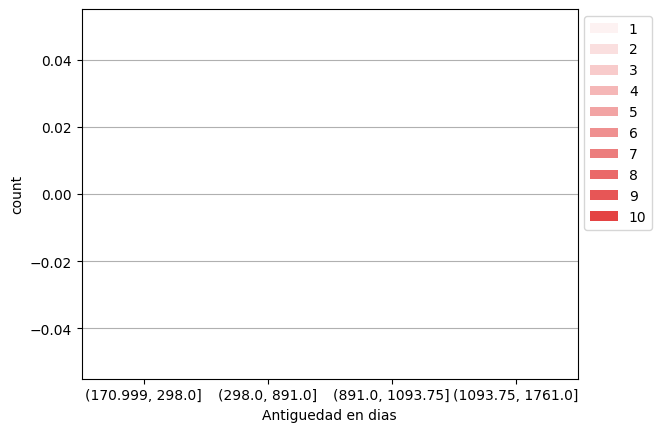

Realizo Cursos, Antiguedad en dias


c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


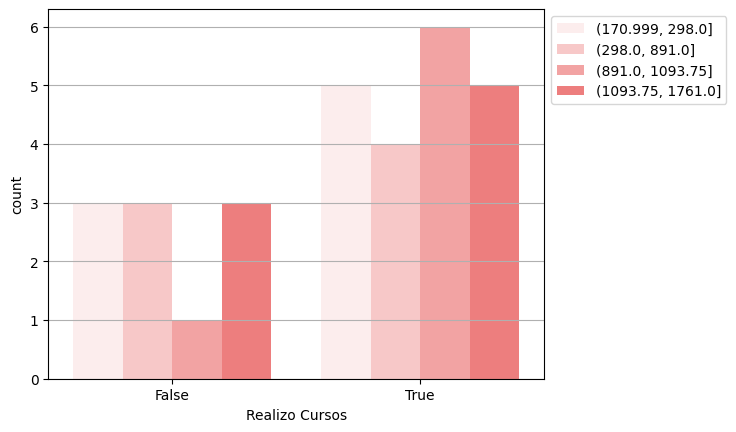

c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


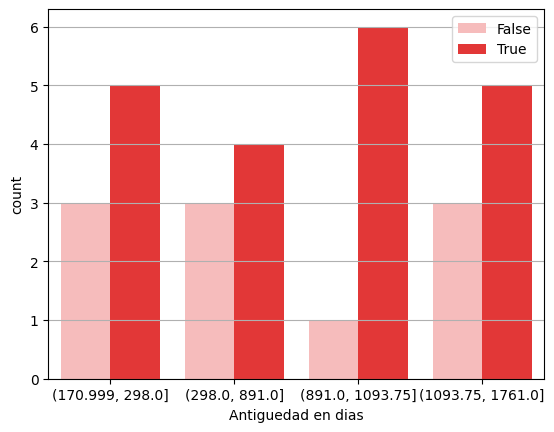

In [30]:
# Gráficos que combinan todos los pares de variables categóricas

# Obtener todas las combinaciones de pares
pares = list(itertools.combinations(categoricas, 2))

for par in pares:
    print(f"{par[0]}, {par[1]}")
    if par[1] != "Manager":
      #TODO: ver por qué rompe cuando se indica hue="Manager"
      sns.countplot(df, x=par[0], hue=par[1], order=orden_variables[par[0]], hue_order=orden_variables[par[1]], palette=colores[par[1]])
      plt.grid(axis="y")
      plt.legend(bbox_to_anchor=(1,1))
      plt.show()

      sns.countplot(df, x=par[1], hue=par[0], order=orden_variables[par[1]], hue_order=orden_variables[par[0]], palette=colores[par[0]])
      plt.grid(axis="y")
      plt.legend(bbox_to_anchor=(1,1))
      plt.show()

In [31]:
df["Tiempo recruitment numerico"] = df["Tiempo recruitment"].astype("object")
# df["prop"] = df["Antiguedad semanas"] / df["Tiempo recruitment numerico"]
# sns.boxplot(data=df, x="prop")

In [32]:
df[["Area","Manager"]].value_counts()

Area        Manager
Ventas      8          6
Compras     2          5
IT          5          5
            7          3
Auditoria   10         2
Marketing   1          2
            9          2
Producción  4          2
            6          2
Legales     3          1
Name: count, dtype: int64

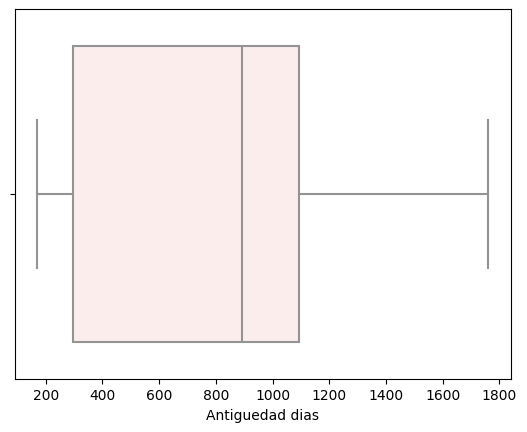

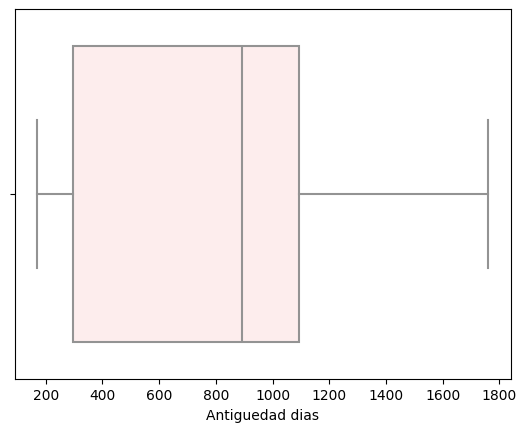

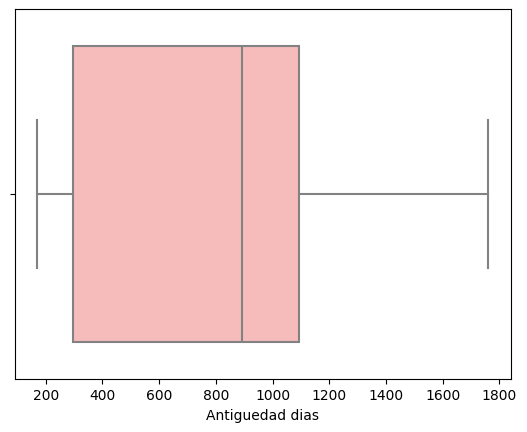

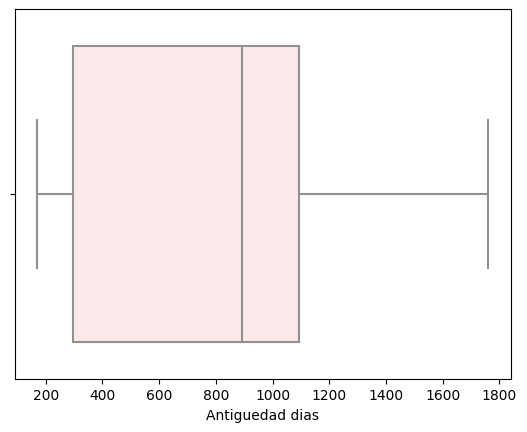

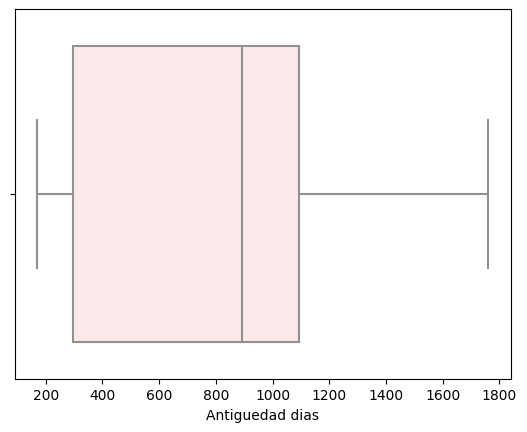

c:\Users\alejo\python\bootcamp-ds-mlops\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


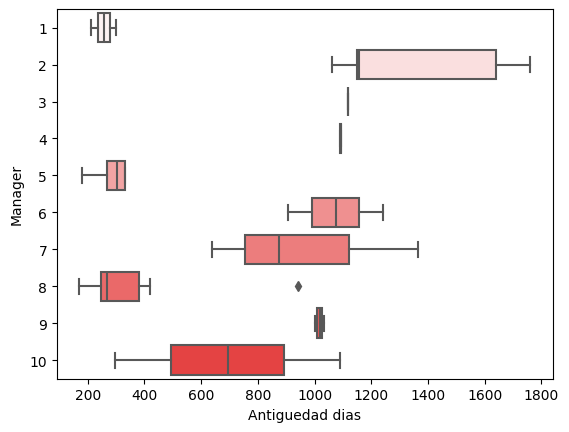

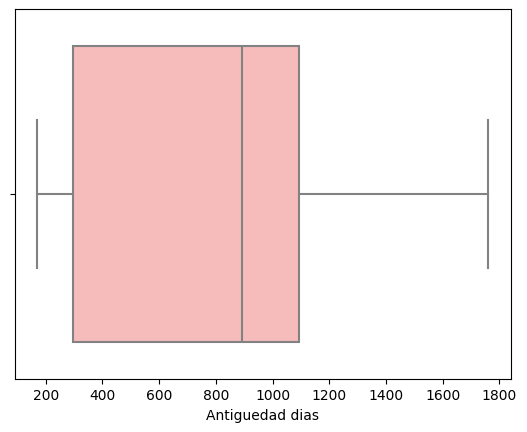

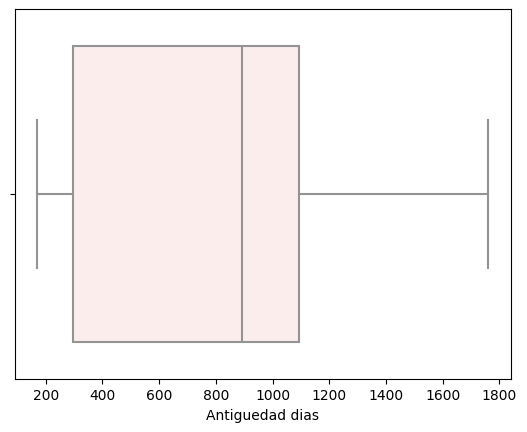

In [33]:
for variable in categoricas:
  if variable != "Tiempo recruitment":
    if variable != "Tiempo recruitment numerico":
      if variable == "Manager":
        #TODO: ver por qué rompe cuando se indica hue="Manager"
        sns.boxplot(data=df, x="Antiguedad dias", y=variable, hue_order=orden_variables[variable], palette=colores[variable])
      else:
        sns.boxplot(data=df, x="Antiguedad dias", hue=variable, hue_order=orden_variables[variable], palette=colores[variable])
  # plt.grid(axis="x")
  plt.show()

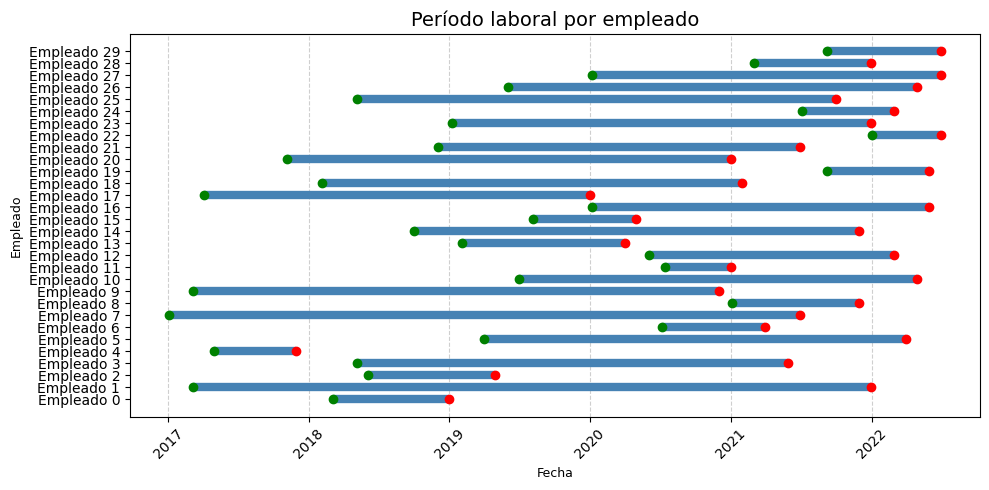

In [34]:
# Crear la figura
plt.figure(figsize=(10, 5))

# Dibujar una barra (línea horizontal) por cada empleado
for i, row in df.iterrows():
    plt.hlines(
        y="Empleado " + str(i),
        xmin=row["Fecha comienzo"],
        xmax=row["Fecha fin"],
        color="steelblue",
        linewidth=6
    )
    # Agregar puntos al inicio y al final
    plt.plot(row["Fecha comienzo"], "Empleado " + str(i), "o", color="green")
    plt.plot(row["Fecha fin"], "Empleado " + str(i), "o", color="red")

# Personalización del gráfico
plt.title("Período laboral por empleado", fontsize=14)
plt.xlabel("Fecha", fontsize=9)
plt.ylabel("Empleado", fontsize=9)
plt.xticks(rotation=45)
plt.grid(axis="x", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

In [35]:
# Bins por meses/años, contar despidos

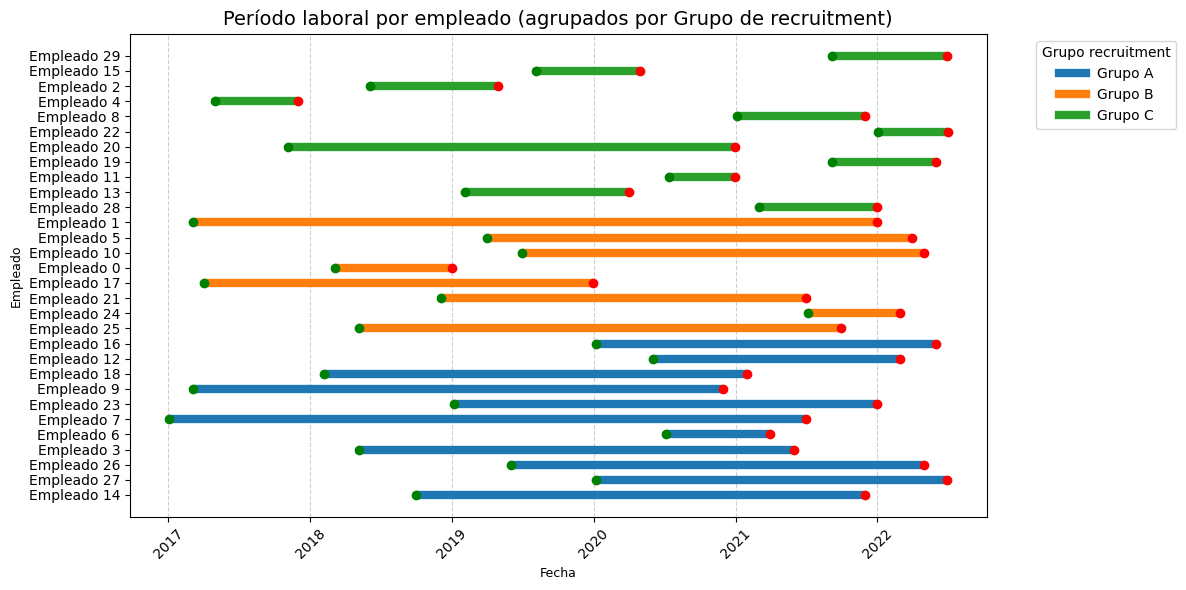

In [36]:
# Ordenar por Area para que queden agrupados en el eje Y
df = df.sort_values(by="Grupo recruitment")

# Crear la figura
plt.figure(figsize=(12, 6))

# Asignar un color distinto por Grupo de recruitment
grupoRec = df["Grupo recruitment"].unique()
colores = plt.cm.tab10.colors  # paleta de colores (10 colores)
color_map = {area: colores[i % len(colores)] for i, area in enumerate(grupoRec)}

# Dibujar una barra (línea horizontal) por cada empleado
for i, row in df.iterrows():
    plt.hlines(
        y="Empleado " + str(i),
        xmin=row["Fecha comienzo"],
        xmax=row["Fecha fin"],
        color=color_map[row["Grupo recruitment"]],
        linewidth=6
    )
    # Agregar puntos al inicio y al final
    plt.plot(row["Fecha comienzo"], "Empleado " + str(i), "o", color="green")
    plt.plot(row["Fecha fin"], "Empleado " + str(i), "o", color="red")

# Personalización del gráfico
plt.title("Período laboral por empleado (agrupados por Grupo de recruitment)", fontsize=14)
plt.xlabel("Fecha", fontsize=9)
plt.ylabel("Empleado", fontsize=9)
plt.xticks(rotation=45)
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Agregar leyenda de Area
handles = [plt.Line2D([0], [0], color=color_map[area], lw=6) for area in grupoRec]
plt.legend(handles, grupoRec, title="Grupo recruitment", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

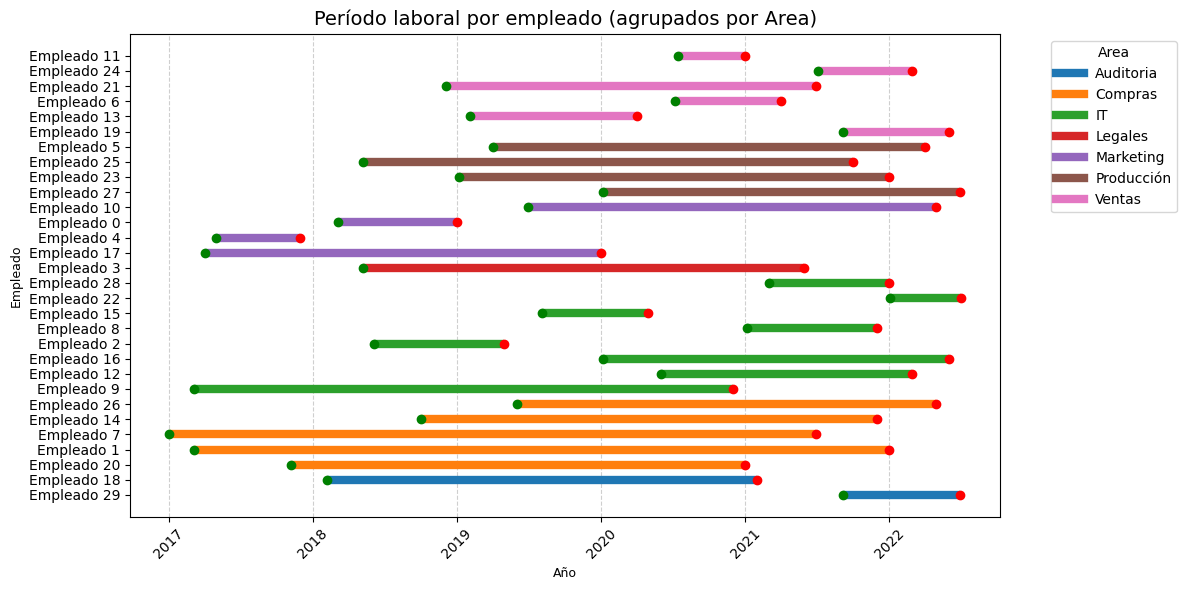

In [37]:
# Ordenar por Area para que queden agrupados en el eje Y
df = df.sort_values(by="Area")

# Crear la figura
plt.figure(figsize=(12, 6))

# Asignar un color distinto por Area
areas = df["Area"].unique()
colores = plt.cm.tab10.colors  # paleta de colores (10 colores)
color_map = {area: colores[i % len(colores)] for i, area in enumerate(areas)}

# Dibujar una barra (línea horizontal) por cada empleado
for i, row in df.iterrows():
    plt.hlines(
        y="Empleado " + str(i),
        xmin=row["Fecha comienzo"],
        xmax=row["Fecha fin"],
        color=color_map[row["Area"]],
        linewidth=6
    )
    # Agregar puntos al inicio y al final
    plt.plot(row["Fecha comienzo"], "Empleado " + str(i), "o", color="green")
    plt.plot(row["Fecha fin"], "Empleado " + str(i), "o", color="red")

# Personalización del gráfico
plt.title("Período laboral por empleado (agrupados por Area)", fontsize=14)
plt.xlabel("Año", fontsize=9)
plt.ylabel("Empleado", fontsize=9)
plt.xticks(rotation=45)
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Agregar leyenda de Area
handles = [plt.Line2D([0], [0], color=color_map[area], lw=6) for area in areas]
plt.legend(handles, areas, title="Area", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

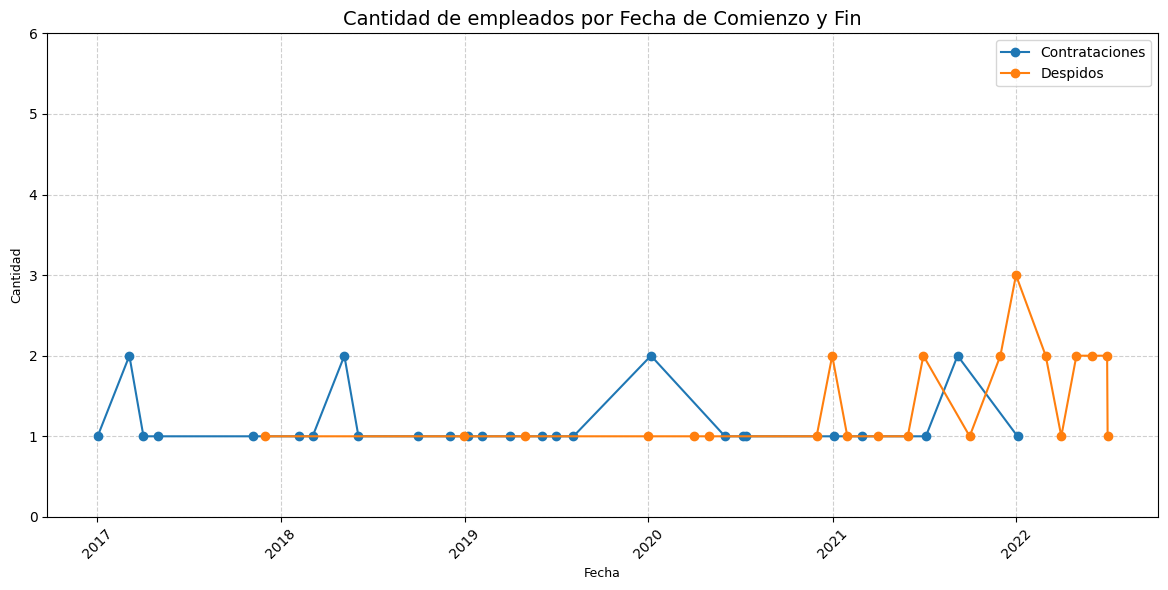

In [38]:
conteo_inicio = (
    df.groupby("Fecha comienzo")
    .size()
    .reset_index(name="Cantidad_inicio")
)

conteo_fin = (
    df.groupby("Fecha fin")
    .size()
    .reset_index(name="Cantidad_fin")
)

plt.figure(figsize=(12, 6))
plt.plot(conteo_inicio["Fecha comienzo"], conteo_inicio["Cantidad_inicio"], marker="o", label="Comienzo")
plt.plot(conteo_fin["Fecha fin"], conteo_fin["Cantidad_fin"], marker="o", label="Fin")

plt.title("Cantidad de empleados por Fecha de Comienzo y Fin", fontsize=14)
plt.xlabel("Fecha", fontsize=9)
plt.ylabel("Cantidad", fontsize=9)
plt.xticks(rotation=45)
plt.grid(axis="both", linestyle="--", alpha=0.6)
plt.legend(["Contrataciones", "Despidos"])
plt.tight_layout()
plt.ylim(0, 6)
plt.show()

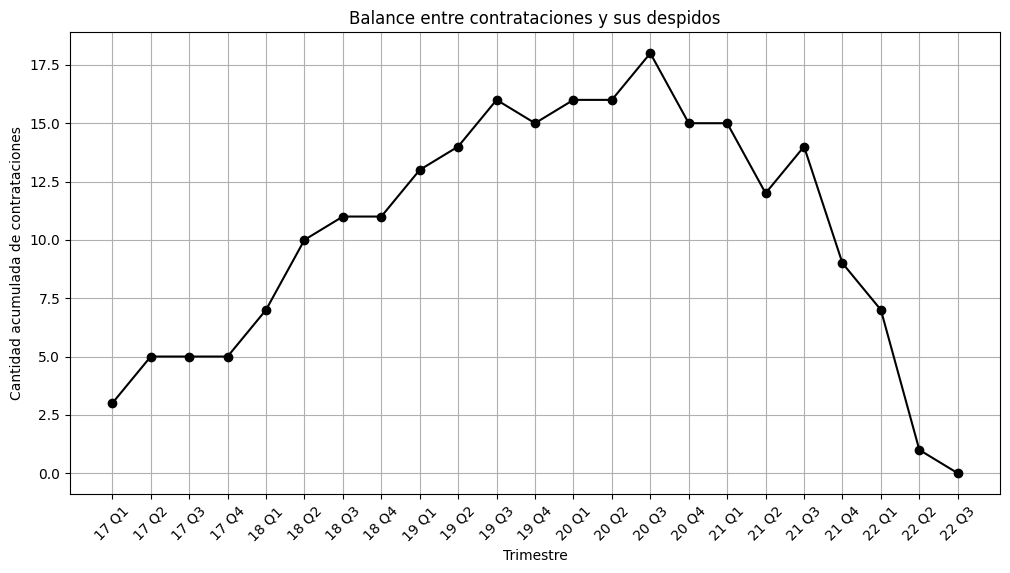

In [39]:
df["Trimestre comienzo"] = df["Fecha comienzo"].dt.to_period("Q")#.astype(str)
df["Trimestre fin"] = df["Fecha fin"].dt.to_period("Q")#.astype(str)

conteo_trimestre_inicio = (
    df.groupby("Trimestre comienzo")
    .size()
    .reset_index(name="Cantidad")
).rename(columns={"Trimestre comienzo": "Trimestre"})
conteo_trimestre_inicio['Trimestre'] = conteo_trimestre_inicio['Trimestre']#.str.slice(2).str.replace('Q', ' Q')

conteo_trimestre_fin = (
    df.groupby("Trimestre fin")
    .size()
    .reset_index(name="Cantidad")
).rename(columns={"Trimestre fin": "Trimestre"})
conteo_trimestre_fin['Trimestre'] = conteo_trimestre_fin['Trimestre']#.str.slice(2).str.replace('Q', ' Q')

conteo_final = pd.merge(conteo_trimestre_inicio, conteo_trimestre_fin, how="outer", on="Trimestre").fillna(0)
conteo_final["Balance"] = conteo_final["Cantidad_x"] - conteo_final["Cantidad_y"]
conteo_final["Balance acumulado"] = conteo_final["Balance"].cumsum()

trimestres_completos = pd.period_range(conteo_final["Trimestre"].min(),
                                       conteo_final["Trimestre"].max(),
                                       freq="Q")
df_trimestres = pd.DataFrame({"Trimestre": trimestres_completos})
conteo_final = pd.merge(conteo_final, df_trimestres, how="outer", on="Trimestre").bfill(axis=0)
conteo_final["Trimestre"] = conteo_final["Trimestre"].astype(str).str.slice(2).str.replace('Q', ' Q')

plt.figure(figsize=(12, 6))
plt.plot(conteo_final["Trimestre"], conteo_final["Balance acumulado"], marker="o", label="Balance acumulado", color="black")

plt.title("Balance entre contrataciones y sus despidos")
plt.xlabel("Trimestre")
plt.ylabel("Cantidad acumulada de contrataciones")
plt.xticks(rotation=45)
plt.yticks
plt.grid(True)
plt.show()